In [1]:
import pandas as pd
from datetime import datetime
import time
from nba_api.stats.static import teams
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
pd.set_option('display.max_columns', 500)

In [2]:
# NBA'deki tüm takımları al
all_teams = teams.get_teams()

In [3]:
NBA_Finals_MVP = pd.read_csv('D:/Work/Yüksek Lisans/tez/NBA Finals and MVP.csv')
teams_df = pd.read_feather('D:/Work/Yüksek Lisans/tez/teams_all_games.feather')
play_off = pd.read_excel('D:/Work/Yüksek Lisans/tez/play_off_champs.xlsx')
teams_regions = pd.read_csv('D:/Work/Yüksek Lisans/tez/NBA_Teams_East_West.csv')
last_10_years_championship = pd.read_csv('D:/Work/Yüksek Lisans/tez/NBA_Last_10_Champions.csv')

In [4]:
all_teams_df = pd.DataFrame(all_teams)

In [5]:
teams_df['GAME_DATE'] = pd.to_datetime(teams_df['GAME_DATE'])
teams_df[['Home','Away']] = teams_df['MATCHUP'].str.split('@|vs.',expand=True)
teams_df['Away'] = teams_df['Away'].str.replace(' ','',regex=True)
teams_df['Home'] = teams_df['Home'].str.replace(' ','',regex=True)

C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_13056\946502563.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  teams_df['GAME_DATE'] = pd.to_datetime(teams_df['GAME_DATE'])


In [6]:
teams_df[['start','end']] = teams_df['SEASON'].str.split('-',expand=True)
teams_df[['start','end']] = teams_df[['start','end']].astype(int)
teams_df = teams_df[teams_df['end'] >= 20].drop(columns = ['start','end'])

In [7]:
general_stats_last_10_years = teams_df.groupby('Home')[['PTS','TOV','OREB', 'DREB', 'REB', 'AST', 'STL','BLK', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA','FT_PCT']].sum().reset_index()
general_stats_last_10_years[['FG_PCT','FG3_PCT','FT_PCT']] = general_stats_last_10_years[['FG_PCT','FG3_PCT','FT_PCT']].apply(lambda x: x / 6)

last_game_date = teams_df.groupby(['Home','SEASON']).agg({'GAME_DATE':'max'}).reset_index()
teams_skore_each_season = last_game_date.merge(teams_df[['Home','W','L','GAME_DATE','Game_ID','SEASON']], on=['GAME_DATE','Home','SEASON'], how='left')
teams_regions.rename(columns={'Team Abbreviation':'Home'},inplace=True)

teams_skore_each_season = teams_skore_each_season.merge(teams_regions,on=['Home'], how='left')
win_lose_last_10_years = teams_skore_each_season.groupby('Home')[['W','L']].sum().reset_index()
general_stats_last_10_years = general_stats_last_10_years.merge(win_lose_last_10_years, on = ['Home'], how= 'left')

In [8]:
all_teams_df.rename(columns={'abbreviation':'Home'},inplace=True)
teams_skore_each_season = teams_skore_each_season.merge(all_teams_df[['id','Home','full_name','city','year_founded']], on=['Home'], how='left')

In [9]:
East_play_off_df = pd.DataFrame()
West_play_of_df = pd.DataFrame()
for season in teams_skore_each_season['SEASON'].unique():
    season_df = teams_skore_each_season[teams_skore_each_season['SEASON'] == season]
    East_play_off_by_season = season_df[season_df['Region'] == 'East'].sort_values(by='W',ascending=False).reset_index(drop=True).head(8)
    West_play_off_by_season = season_df[season_df['Region'] == 'West'].sort_values(by='W',ascending=False).reset_index(drop=True).head(8)
    East_play_off_df = pd.concat([East_play_off_df,East_play_off_by_season],axis=0)
    West_play_of_df = pd.concat([West_play_of_df,West_play_off_by_season],axis=0)
West_play_off_number_data = pd.DataFrame(West_play_of_df['Home'].value_counts()).reset_index()
East_play_off_number_data = pd.DataFrame(East_play_off_df['Home'].value_counts()).reset_index()
play_off_data = pd.concat([West_play_off_number_data,East_play_off_number_data],axis=0)

In [12]:
play_off_data = teams_skore_each_season.merge(play_off_data,on=['Home'], how='left').rename(columns={'count':'play_off_count'}).fillna(0)

In [14]:
last_10_years_championship[['start','end']] = last_10_years_championship['Season'].str.split('-',expand=True)
last_10_years_championship[['start','end']] = last_10_years_championship[['start','end']].astype(int)
last_10_years_championship = last_10_years_championship[last_10_years_championship['end'] >= 20].drop(columns = ['start','end'])

In [15]:
champions = last_10_years_championship.groupby('Champion')[['Series Result']].count().reset_index().rename(columns={'Champion':'full_name','Series Result':'championship'})
loser_finalist = last_10_years_championship.groupby('Finalist')[['Series Result']].count().reset_index().rename(columns={'Finalist':'full_name','Series Result':'Loser_Finalist'})

In [16]:
play_off_data = play_off_data.merge(champions, on=['full_name'], how='left').merge(loser_finalist, on = ['full_name'],how='left').fillna(0)
play_off_data = play_off_data[['Home','Region','city', 'year_founded', 'play_off_count', 'championship','Loser_Finalist']].drop_duplicates().reset_index(drop=True)

In [17]:
play_off_data[['championship','Loser_Finalist','play_off_count']] = play_off_data[['championship','Loser_Finalist','play_off_count']].astype(int)
general_stats_last_10_years = general_stats_last_10_years.merge(play_off_data[['Home', 'play_off_count', 'Region','city','year_founded', 'championship', 'Loser_Finalist']],on=['Home'], how='left')

In [19]:
kmeans_data = general_stats_last_10_years.drop(columns=['Home','year_founded','PTS'])

In [20]:
# Encode categorical variables (country, os) using one-hot encoding
data_encoded = pd.get_dummies(kmeans_data, columns=['city','Region'],drop_first=True,dtype=int)

# Scale the features for better clustering performance
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data_encoded)

# Train a K-Means model for anomaly detection
kmeans = KMeans(n_clusters=4, random_state=42)
general_stats_last_10_years['cluster'] = kmeans.fit_predict(features_scaled)

# Determine anomalies as points far from their cluster centers
general_stats_last_10_years['distance_to_center'] = np.min(kmeans.transform(features_scaled), axis=1)


In [21]:
general_stats_last_10_years.to_feather('teams_clustering_df.feather')

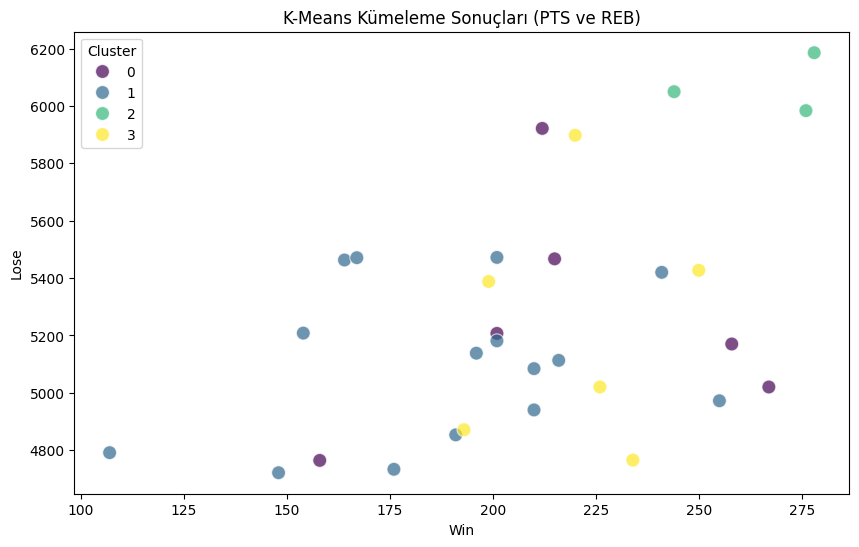

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Örnek olarak 'PTS' ve 'REB' üzerinden görselleştirme
plt.figure(figsize=(10, 6))
sns.scatterplot(data=general_stats_last_10_years, x='W', y='FG3M', hue='cluster', palette='viridis', s=100, alpha=0.7)
plt.title('K-Means Kümeleme Sonuçları (PTS ve REB)')
plt.xlabel('Win')
plt.ylabel('Lose')
plt.legend(title='Cluster')
plt.show()

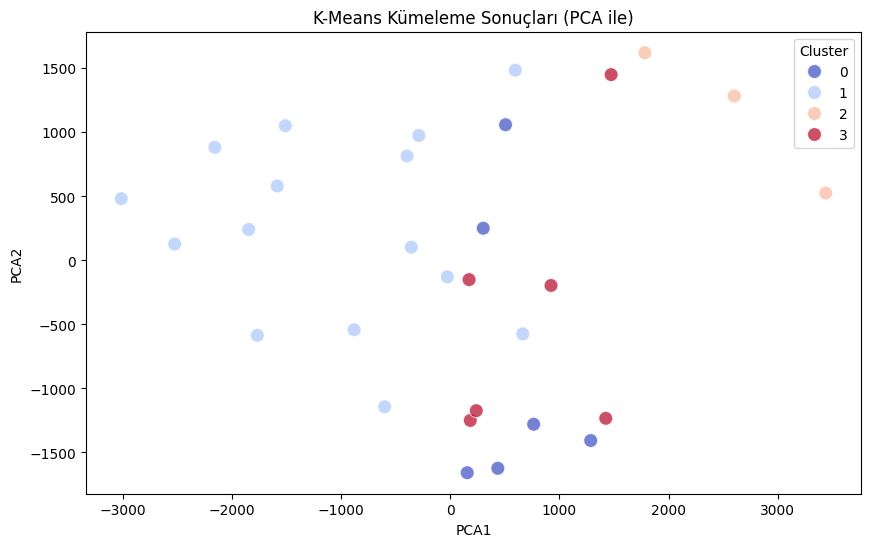

In [24]:
from sklearn.decomposition import PCA

# PCA ile 2 boyuta indirgeme
pca = PCA(n_components=2)
general_stats_last_10_years['PCA1'], general_stats_last_10_years['PCA2'] = zip(*pca.fit_transform(general_stats_last_10_years.drop(['cluster'], axis=1).select_dtypes(include=['float64', 'int64'])))

# Görselleştirme
plt.figure(figsize=(10, 6))
sns.scatterplot(data=general_stats_last_10_years, x='PCA1', y='PCA2', hue='cluster', palette='coolwarm', s=100, alpha=0.7)
plt.title('K-Means Kümeleme Sonuçları (PCA ile)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

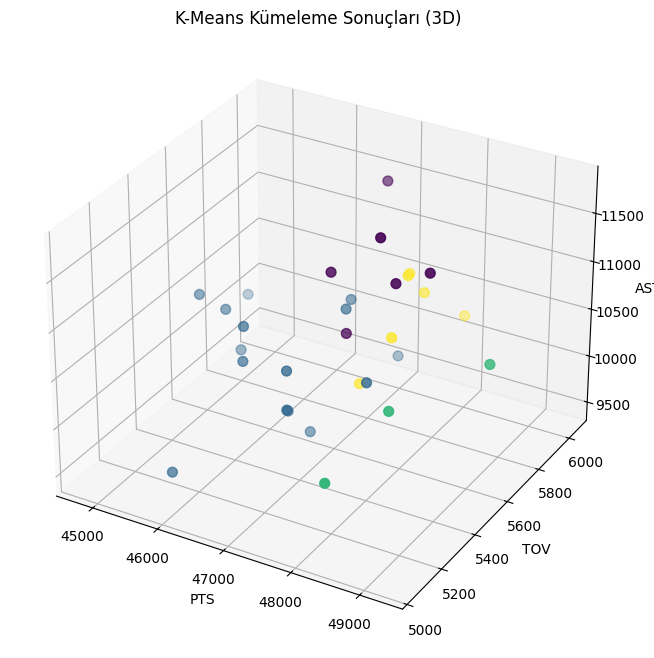

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(general_stats_last_10_years['PTS'], general_stats_last_10_years['TOV'], general_stats_last_10_years['AST'], c=general_stats_last_10_years['cluster'], cmap='viridis', s=50)
ax.set_title('K-Means Kümeleme Sonuçları (3D)')
ax.set_xlabel('PTS')
ax.set_ylabel('TOV')
ax.set_zlabel('AST')

plt.show()

In [31]:
import plotly.express as px

# 3D scatter plot
fig = px.scatter_3d(
    general_stats_last_10_years, 
    x='PTS', 
    y='W', 
    z='AST', 
    color='cluster', 
    symbol='cluster',
    size_max=10,
    title='K-Means Kümeleme Sonuçları (3D)',
    opacity=0.8,
    color_continuous_scale=px.colors.sequential.Viridis, # Daha güzel bir renk paleti
    labels={
        "PTS": "Points Scored",
        "W": "Win",
        "AST": "Assists",
        "cluster": "Cluster"
    }
)

# Grafik düzenlemeleri
fig.update_layout(
    scene=dict(
        xaxis=dict(title='PTS (Points)', titlefont=dict(size=14), backgroundcolor="rgb(240, 240, 240)"),
        yaxis=dict(title='W (Win)', titlefont=dict(size=14), backgroundcolor="rgb(240, 240, 240)"),
        zaxis=dict(title='AST (Assists)', titlefont=dict(size=14), backgroundcolor="rgb(240, 240, 240)"),
    ),
    scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),  # Perspektif
    margin=dict(l=0, r=0, b=0, t=40),  # Kenar boşlukları
    legend=dict(title="Cluster", font=dict(size=12)),
    title_font=dict(size=18),
    template="plotly_white"  # Beyaz arka plan
)

# Veri noktalarını belirginleştirme
fig.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')))

# Grafiği göster
fig.show()

In [34]:
# 3D scatter plot
fig = px.scatter_3d(
    general_stats_last_10_years, 
    x='FTA', 
    y='FGA', 
    z='FG3A', 
    color='cluster', 
    symbol='cluster',
    size_max=10,
    title='K-Means Kümeleme Sonuçları (3D)',
    opacity=0.8,
    color_continuous_scale=px.colors.sequential.Viridis, # Daha güzel bir renk paleti
    labels={
        "FTA": "FTA",
        "FGA": "FGA",
        "FG3A": "3 points attempt",
        "cluster": "Cluster"
    }
)

# Grafik düzenlemeleri
fig.update_layout(
    scene=dict(
        xaxis=dict(title='FTA (FTA)', titlefont=dict(size=14), backgroundcolor="rgb(240, 240, 240)"),
        yaxis=dict(title='FGA (FGA)', titlefont=dict(size=14), backgroundcolor="rgb(240, 240, 240)"),
        zaxis=dict(title='FG3A (3 Points Attempt)', titlefont=dict(size=14), backgroundcolor="rgb(240, 240, 240)"),
    ),
    scene_camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),  # Perspektif
    margin=dict(l=0, r=0, b=0, t=40),  # Kenar boşlukları
    legend=dict(title="Cluster", font=dict(size=12)),
    title_font=dict(size=18),
    template="plotly_white"  # Beyaz arka plan
)

# Veri noktalarını belirginleştirme
fig.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')))

# Grafiği göster
fig.show()

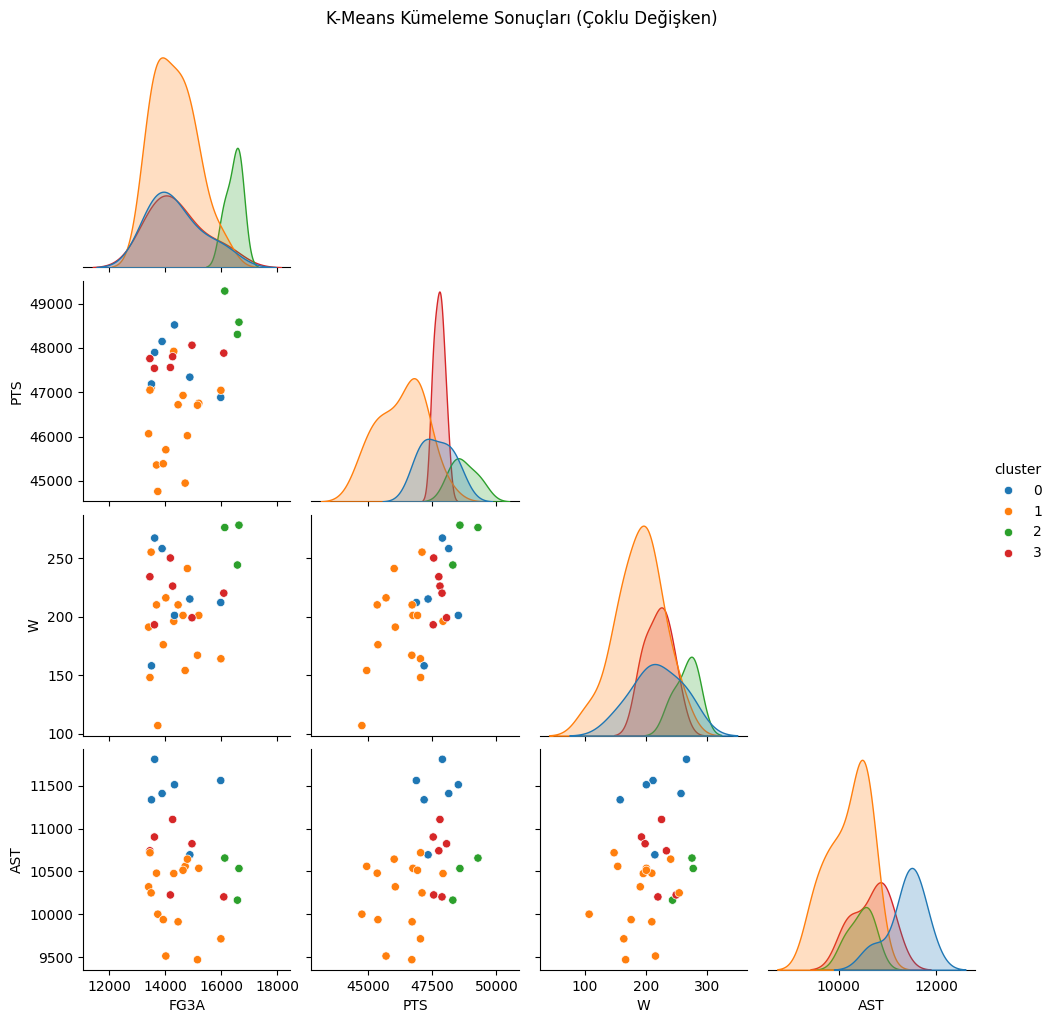

In [27]:
sns.pairplot(general_stats_last_10_years, vars=['FG3A', 'PTS', 'W', 'AST'], hue='cluster', palette='tab10', diag_kind='kde', corner=True)
plt.suptitle('K-Means Kümeleme Sonuçları (Çoklu Değişken)', y=1.02)
plt.show()